# Simulation notebook

This notebook contains several simulations to get started with sample design. It's intended to be used during sample design iteration, as well as during the measurement process to understand the data. It has a convenient widget that lets you tune the voltages on each electrode, and plots the electron potential. There are also more detailed simulations near the end of this notebook, that let you explore the trap area in greater detail. The data needed for all the simulations below can be found in the folder `simulation/exported_maxwell_data`.

In [10]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py, matplotlib
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm
from ipywidgets import interact
from scipy.constants import electron_mass as me, elementary_charge as qe

# Make sure the analysis folder is visible in your path. If not, append to the system path here:
# sys.path.append(r"the_path_of_M018_Yggdrasil_folder")

from analysis.modules import common, kfit, interpolate_slow, trap_analysis, import_data, artificial_anneal as anneal
    
# If you're running on a macbook, uncomment the following line for more crisp plots.
# %config InlineBackend.figure_format='retina'

# For inline plots
%matplotlib inline

In [2]:
# If you run jupyter lab in dark mode, the following configures plots so that they're visible
def dark_mode_compatible(dark_mode_color=r'#86888A'):
    matplotlib.rc('axes', edgecolor=dark_mode_color)
    matplotlib.rc('text', color=dark_mode_color)
    matplotlib.rc('xtick', color=dark_mode_color)
    matplotlib.rc('ytick', color=dark_mode_color)
    matplotlib.rc('axes', labelcolor=dark_mode_color)
    matplotlib.rc('axes', facecolor='none')
    matplotlib.rc('figure', edgecolor='none')#.edgecolor', (1, 1, 1, 0))
    matplotlib.rc('figure', facecolor='none')# (1, 1, 1, 0))
    
dark_mode_compatible(dark_mode_color=r'#86888A')

Our notebook server is launched in the analysis folder.

In [28]:
os.getcwd()

'/Users/gkoolstra/Documents/Code/M018_Yggdrasil/analysis'

# Resonator microwave potential

The goal of this section is to extract the electric field strength at the center of the channel, which is needed to extract the coupling strength to the electron. This section assumes a datafile from a 2D Maxwell simulation of the resonator, where the left (right) center pin was set to +0.5 V (-0.5 V). Note that the simulation geometry is of the full cross-section, and not half the cross-section, because the voltages need to be applied in an anti-symmetric fashion.

In [47]:
# Load the data from the dsp file: 
path=r"../simulation/exported_maxwell_data/Resonator only/2D Differential Mode Ex.dsp"
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

Because we have two-dimensional data of the electric field strength $E_x$, we can investigate what happens at several heights (measured from the bottom of the channel, $h$. Note that $h$ is measured in microns in this case (this is set by the units of the Maxwell simulation file).

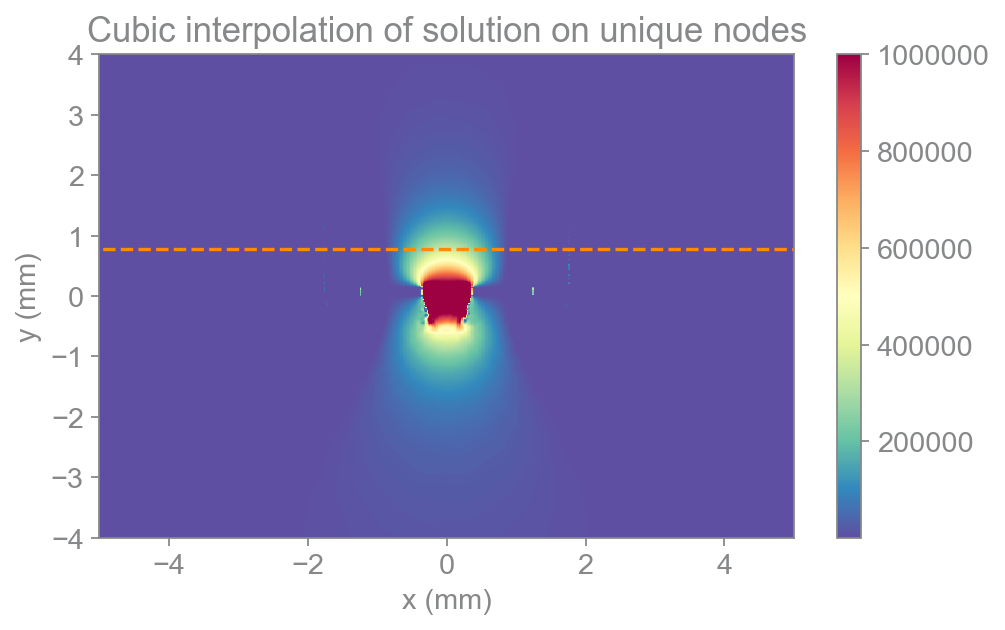

In [49]:
h = 0.78
plt.figure(figsize=(7.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=np.linspace(-5, 5, 501), 
                                                     yeval=np.linspace(-4, 4, 1001), clim=(1e3, 1e6), 
                                                     plot_axes='xy', cmap=plt.cm.Spectral_r)

plt.hlines(h, bounding_box[0], bounding_box[1], linestyles='--', color='darkorange')

Let's take a slice at the specified $h$ and plot the slice as function of the across-channel coordinate $x$. 

The mean electric field over the range (-0.25, 0.25) is 0.3403 V/um.


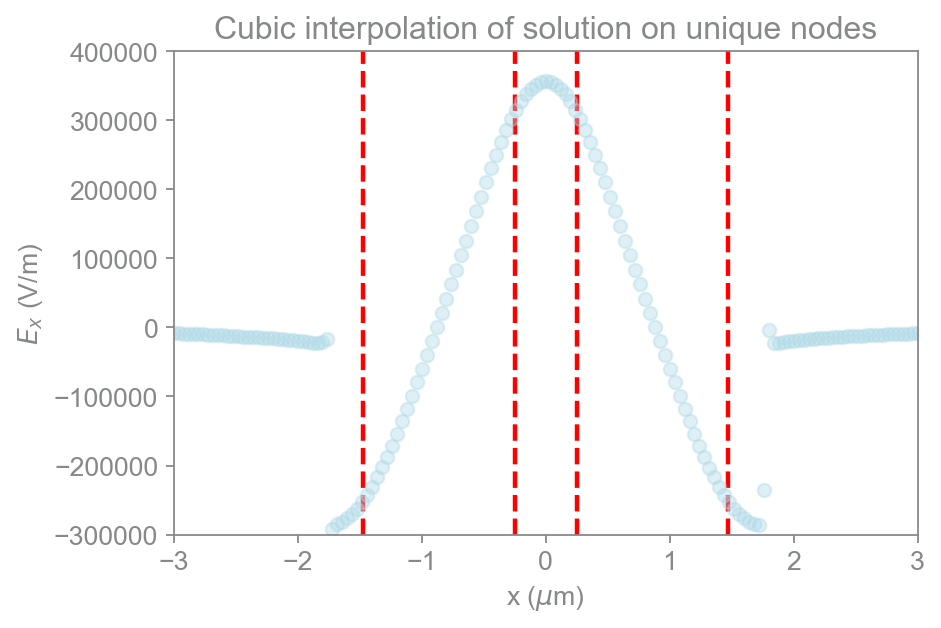

In [31]:
electron_min_x = -0.25 #minimum value of x for the electron
electron_max_x = 0.25 #maximum value of x for the electron

plt.figure(figsize=(6.,4.))
common.configure_axes(12)
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=np.linspace(-10, 10, 501), 
                                                              yeval=h, clim=(-3E5, 4E5), linestyle='None', 
                                                              plot_axes='xy', cmap=plt.cm.viridis, 
                                                              **common.plot_opt('lightblue', msize=6))
plt.xlim(-3, 3)
plt.ylabel(r"$E_x$ (V/m)")
plt.xlabel("x ($\mu$m)")
plt.vlines((-0.25, 0.25, -1.47, 1.47), -3E5, 4E5, colors='r', lw=2.0, linestyles='--')

meanEx = np.mean(Uinterp[0][np.logical_and(xinterp[0]>electron_min_x , xinterp[0]<electron_max_x)])
print("The mean electric field over the range %s is %.4f V/um." % ( (electron_min_x, electron_max_x), meanEx/1E6))

We want to make sure that electrons on the resonator experience a strong electric field which is mostly constant at the center of the channel.

# Resonator DC bias potential

This section of the notebook investigates the natural frequency of the potential generated by the microwave resonator, when it is biased with a voltage $V_\mathrm{res}$. Ideally, the natural frequency remains far detuned from the microwave resonator frequency at the voltage where you expect a crossing with the single electron. 

The data for this simulation come from a two-dimensional Maxwell simulation of the resonator cross-section. In contrast to the previous section, the voltage applied to the left and right resonator center pin are equal (+1 V) for this simulation (instead of equal and opposite in sign). Therefore, we cannot use the same exported `.dsp` file to run this simulation. In addition, since the Maxwell simulation geometry can be reduced to a symmetric problem, we only need to simulate half of the cross-section and mirror the simulation around the channel-axis. The mirroring is done in the cells below and we'll use this technique more often later in this notebook. See for example the command `construct_symmetric_y`. 

In [32]:
# Load the data from the dsp file: 
path = r"../simulation/exported_maxwell_data/Resonator only/ResonatorBiasSymmetricPotential_1100nm.dsp"
#r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/V6.3/DCBiasPotentials/channel_1100nm_L3_450nm.dsp"
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160530 - M016v5 resonator xz cut magE.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

Again, since we have two-dimensional data of the potential, it's insightful to take a slice of the data at a specific helium height $h$ (measured in microns in this case). 

<ipython-input-33-c13bb0fdd8d0>:29: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(x_symmetric, y_symmetric, np.log10(Uinterp_symmetric), cmap=plt.cm.Spectral_r, vmin=-2, vmax=0)


Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ====================  ======================
Parameter           Value                   Std
===========  ====================  ======================
a0           -0.5733566437523774   1.647812820189417e-07
a1           0.10113548624835335   1.6657252086423045e-05
a2           0.047050686871342125  0.0003003613637284282
===========  ====================  ======================
f = 30.016 +/- 0.002 GHz


Text(0, 0.5, 'U (eV) at $h$ = 1.00 $\\mu$m')

<Figure size 560x320 with 0 Axes>

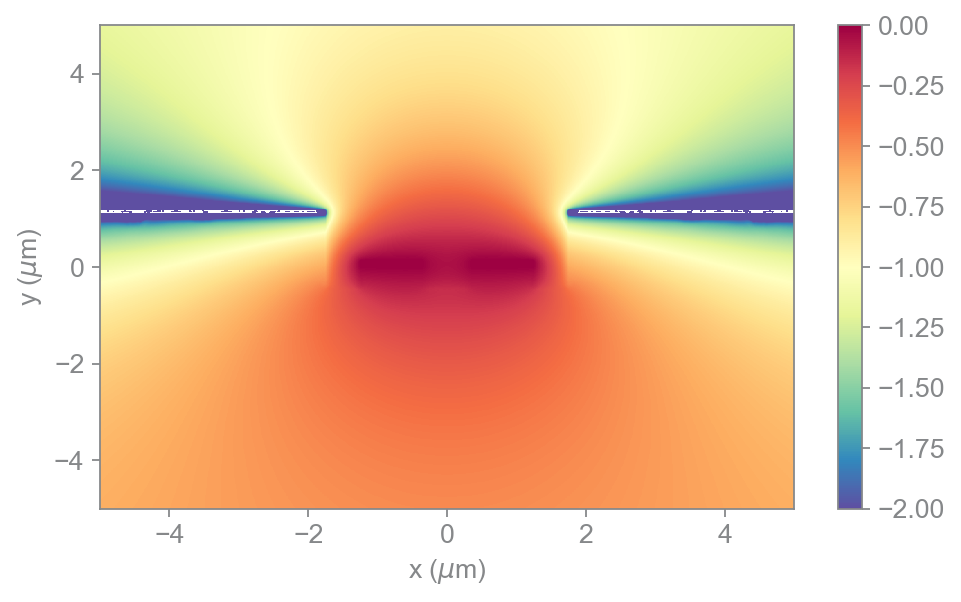

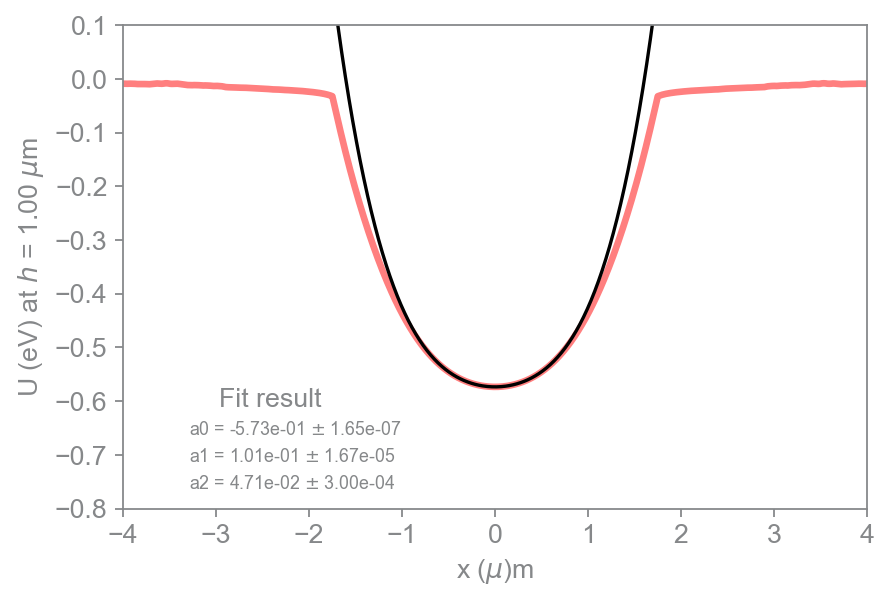

In [33]:
h = 1
fitdomain=(-0.25, 0.25)

xeval = anneal.construct_symmetric_y(-5.0, 501)
yeval = np.linspace(-5, 5, 1001)

plt.figure(figsize=(7.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, 
                                                     yeval=yeval, clim=None, plot_mesh=False, plot_data=False,
                                                     plot_axes='xy', cmap=plt.cm.viridis)

# Mirror around the y-axis
ysize, xsize = np.shape(Uinterp)
Uinterp_symmetric = np.zeros((ysize, 2*xsize))
Uinterp_symmetric[:, :xsize] = Uinterp
Uinterp_symmetric[:, xsize:] = Uinterp[:, ::-1]

x_symmetric = np.zeros((ysize, 2*xsize))
x_symmetric[:, :xsize] = xinterp
x_symmetric[:, xsize:] = -xinterp[:, ::-1]

y_symmetric = np.zeros((ysize, 2*xsize))
y_symmetric[:, :xsize] = yinterp
y_symmetric[:, xsize:] = yinterp

plt.figure(figsize=(7., 4.))
common.configure_axes(12)
plt.pcolormesh(x_symmetric, y_symmetric, np.log10(Uinterp_symmetric), cmap=plt.cm.Spectral_r, vmin=-2, vmax=0)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
plt.ylim(np.min(y_symmetric), np.max(y_symmetric))

index = common.find_nearest(y_symmetric[:, 0], h)
plt.figure(figsize=(6., 4.))
common.configure_axes(12)
plt.plot(x_symmetric[index, :], -Uinterp_symmetric[index, :], '-', color='r', alpha=0.5, lw=3)

fr, ferr = kfit.fit_poly(x_symmetric[index, :], -Uinterp_symmetric[index, :], mode='even', 
                         fitparams=[0, 0.01, 0.01], domain=fitdomain)

plt.plot(x_symmetric[index, :], kfit.polyfunc_even(x_symmetric[index, :], *fr), color='k')
plt.ylim(-0.8, 0.1)
plt.xlim(-4, 4)

t = trap_analysis.TrapSolver()
t.get_electron_frequency([fr[0], -fr[1]], [ferr[0], ferr[1]]);

plt.xlabel("x ($\mu$)m")
plt.ylabel("U (eV) at $h$ = %.2f $\mu$m"%(h))

And finally, let's explore what happens when we change the resonator voltage $V_\mathrm{res}$. 

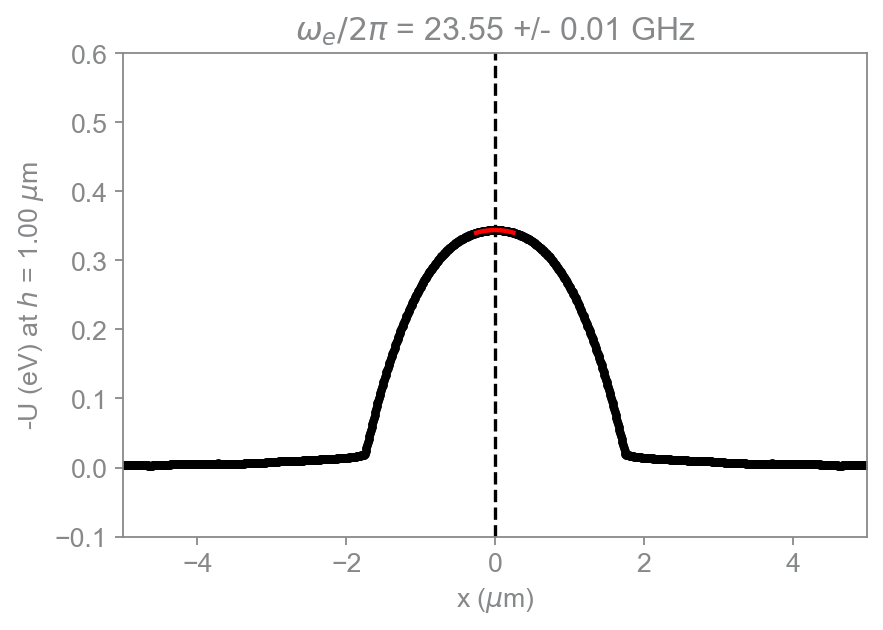

In [34]:
t = trap_analysis.TrapSolver()

def plot_resonator_potential(resonator_voltage=0.6):
    plt.figure(figsize=(6., 4.))
    voltage = resonator_voltage
    V = voltage*Uinterp_symmetric[index,:]
    X = x_symmetric[index,:]
    Y = y_symmetric[:,index]
    
    plt.plot(X, V)
    plt.xlim(min(X), max(X))
    plt.title('$h$ = %.2f $\mu$m, Feature size: 1 $\mu$m'%(h))
  
    if voltage >= 0:
        try:
            fr, ferr = t.fit_electron_potential(X, V, fitdomain=(X[np.argmax(V)]-0.25, 
                                                                 X[np.argmax(V)]+0.25), do_plot=True)
            f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
        except:
            f0, sigmaf0 = np.nan, np.nan
        plt.ylim(-0.1, voltage)
    else:
        f0, sigmaf0 = np.nan, np.nan
        plt.plot(X, V, '.k')
        plt.ylim(voltage, -voltage)
        
    plt.vlines(X[np.argmax(V)], ymin=-0.1, ymax=3.0, colors='k', linestyles='--')
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("-U (eV) at $h$ = %.2f $\mu$m"%(h))
    plt.title("$\omega_e/2\pi$ = {:.2f} +/- {:.2f} GHz".format(f0/1E9, sigmaf0/1E9))
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
        
interact(plot_resonator_potential, resonator_voltage=(0.01, 3, 0.05));

## Nonlinearity as a function of helium height

After running the previous section, we may be interested in the sensitivity of the natural frequency to helium height. We explore the sensitivity in this section, by taking slices of the two-dimensional data at a particular $V_\mathrm{res}$, given by `Voi`. It's important that the sensitivity is not extremely large, because in that case, any change in helium height will result in a large change in the electron ensemble frequency. This may compromise your ability to detect electrons on top of the resonator.

We do not need to load new data for this simulation.

(0.8, 1.1)

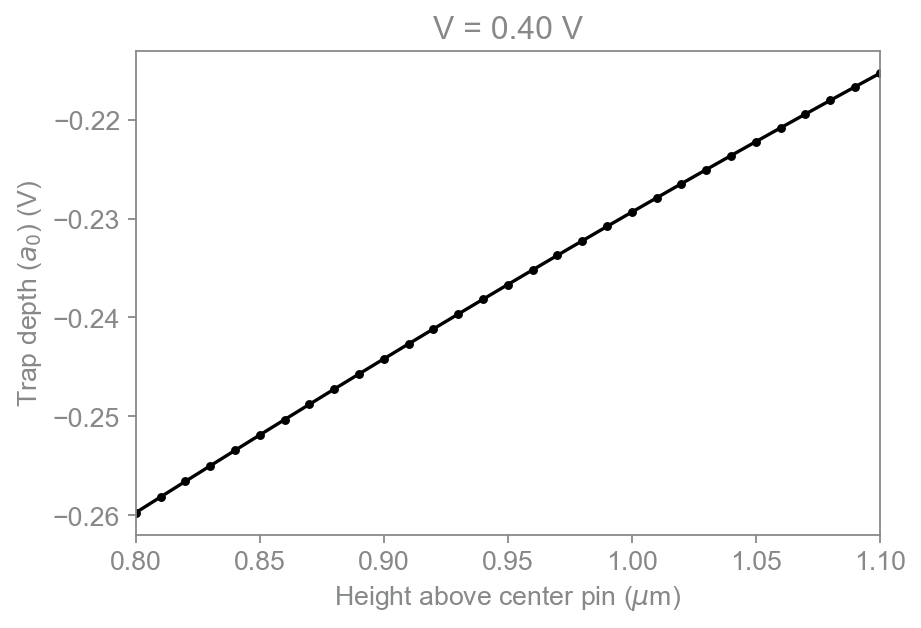

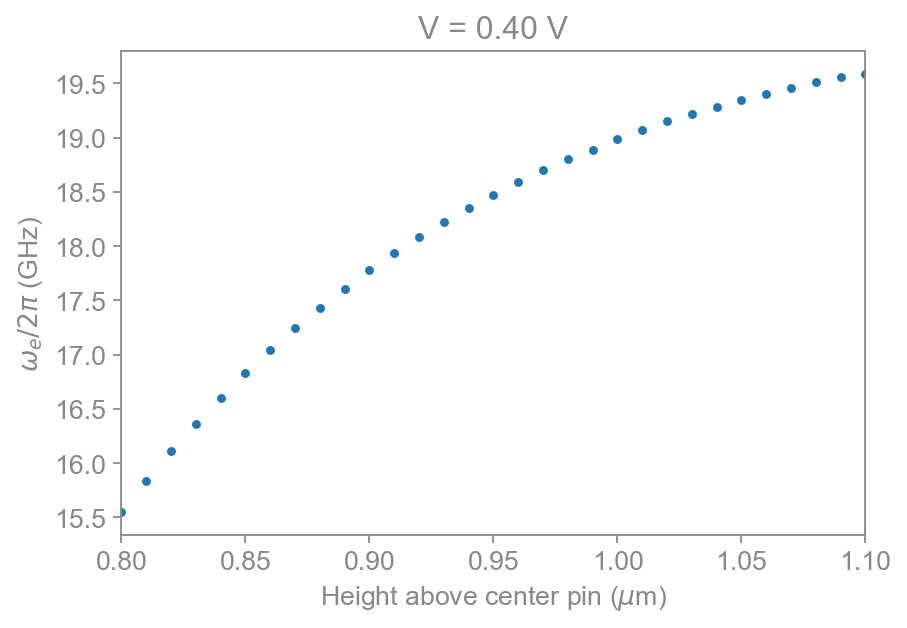

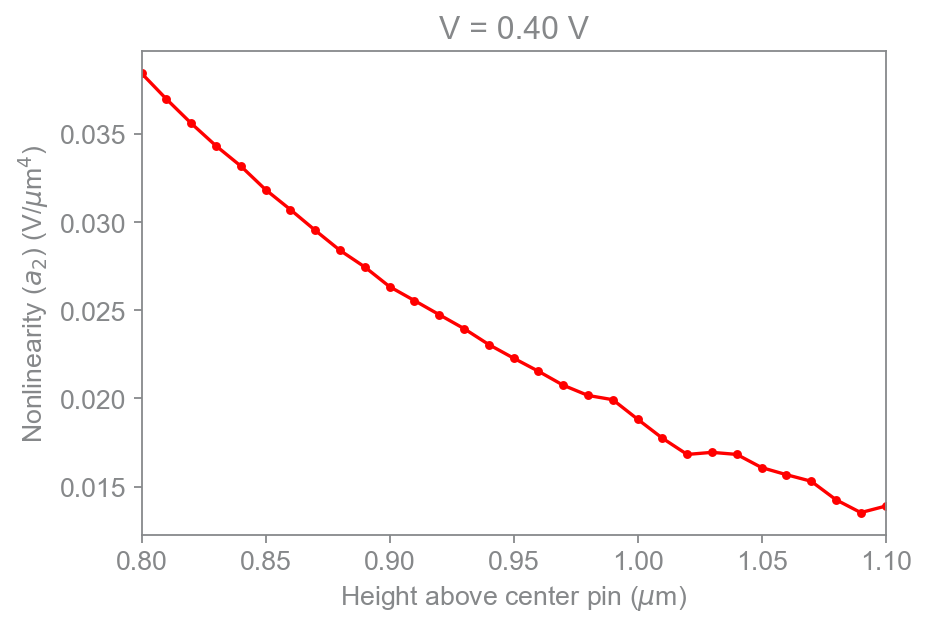

In [35]:
hs = np.linspace(0.8, 1.1, 31)
Voi = 0.4
f_e = list()
fitresults = list()
for H in hs:
    domain=(-0.5, 0.5)
    index = common.find_nearest(y_symmetric[:, 0], H)
    fr, ferr = kfit.fit_poly(x_symmetric[index, :], -Voi * Uinterp_symmetric[index, :], mode='even', 
                         fitparams=[0, 0.01, 0.01], domain=fitdomain, verbose=False)

    t = trap_analysis.TrapSolver()
    f_e.append(t.get_electron_frequency([fr[0], -fr[1]], [ferr[0], ferr[1]], verbose=False))
    fitresults.append(fr)
    
fitresults = np.array(fitresults)
plt.figure(figsize=(6., 4.))
plt.title("V = %.2f V"%(Voi))
plt.plot(hs, fitresults[:,0], '.-k')
plt.xlabel("Height above center pin ($\mu$m)")
plt.ylabel("Trap depth ($a_0$) (V)")
plt.xlim(hs[0], hs[-1])

plt.figure(figsize=(6., 4.))
plt.title("V = %.2f V"%(Voi))
plt.errorbar(hs, np.array(f_e)[:,0]/1E9, yerr=np.array(f_e)[:,1]/1E9, fmt='.')
plt.xlim(hs[0], hs[-1])
plt.xlabel("Height above center pin ($\mu$m)")
plt.ylabel("$\omega_e/2\pi$ (GHz)")

plt.figure(figsize=(6., 4.))
plt.title("V = %.2f V"%(Voi))
plt.plot(hs, fitresults[:,2], '.-r')
plt.xlabel("Height above center pin ($\mu$m)")
plt.ylabel("Nonlinearity ($a_2$) (V/$\mu$m$^4$)")
plt.xlim(hs[0], hs[-1])

In this case we see that the natural frequency remains far detuned from the resonance frequency of the microwave resonator, and it is not particularly sensitive.

# Greater trap area simulation

Let's move on to the trap area, where we expect to be able to keep electrons confined in a small electrostatic potential. The goal of this section is to visualize the potential around the dot and show how the 4 different electrodes change the potential. Also, this simulation should tell you whether it's possible to load electrons into the dot. To run the code below make sure you have the four necessary files: 
- Resonator.dsp
- Trap.dsp
- ResonatorGuard.dsp
- TrapGuard.dsp

These files are outputs from a 3D Maxwell trap area simulation, and are exported at a specific z-coordinate (the anticipated helium height). It assumes that the simulation geometry was symmatric around the channel axis and mirrors the data here after loading and interpolating. The results of the first cell show four plots which correspond to the potential energy when 1 V is applied to the resonator, trap , resonator guard and trap guard electrodes, respectively.

<Figure size 1120x320 with 0 Axes>

<Figure size 560x320 with 0 Axes>

<Figure size 1120x320 with 0 Axes>

<Figure size 560x320 with 0 Axes>

<Figure size 1120x320 with 0 Axes>

<Figure size 560x320 with 0 Axes>

<Figure size 1120x320 with 0 Axes>

<Figure size 560x320 with 0 Axes>

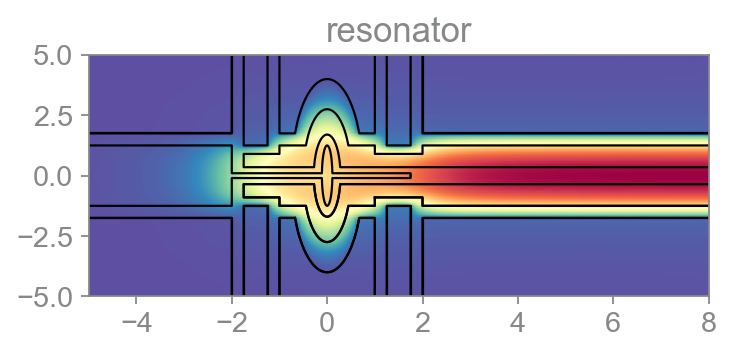

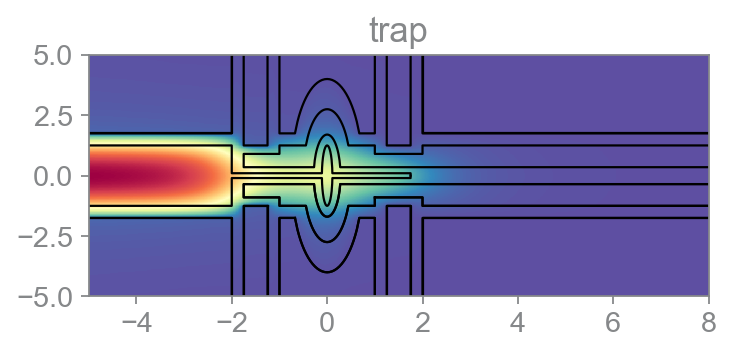

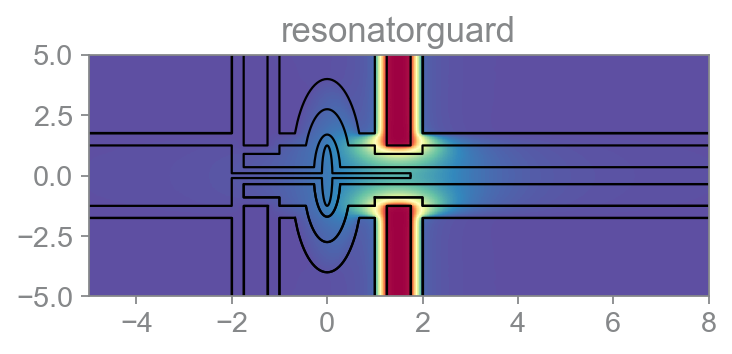

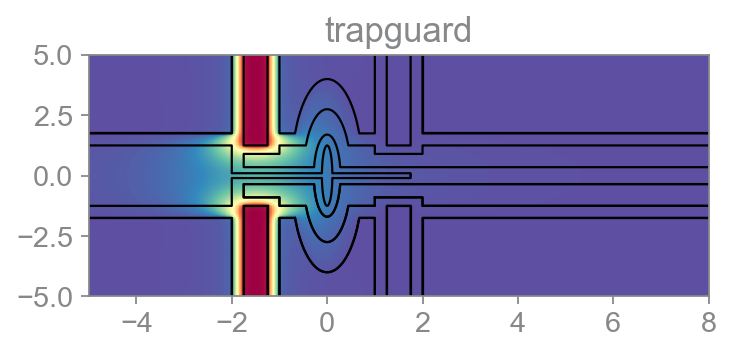

In [52]:
datafolder = r"../simulation/exported_maxwell_data/Greater trap area"
    
# Evaluate all files in the range
yeval = anneal.construct_symmetric_y(-5, 201)
xeval = np.linspace(-5, 8, 1001)

datafiles = ["Resonator.dsp",
             "Trap.dsp",
             "ResonatorGuard.dsp",
             "TrapGuard.dsp"]
output = list()
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(14.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafolder, datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, 
                                                                     nodes, 
                                                                     elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter

    plt.figure(figsize=(7.,4.))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, 
                                                                  xeval=xeval, 
                                                                  yeval=yeval, 
                                                                  clim=None, 
                                                                  plot_mesh=False, 
                                                                  plot_data=False,
                                                                  plot_axes='xy', 
                                                                  cmap=plt.cm.viridis)

    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((2 * ysize, xsize))
    Uinterp_symmetric[:ysize, :] = Uinterp
    Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

    y_symmetric = np.zeros((2 * ysize, xsize))
    y_symmetric[:ysize, :] = yinterp
    y_symmetric[ysize:, :] = -yinterp[::-1, :]

    x_symmetric = np.zeros((2 * ysize, xsize))
    x_symmetric[:ysize, :] = xinterp
    x_symmetric[ysize:, :] = xinterp
    
    output.append({'name' : name, 
                   'V' : np.array(Uinterp_symmetric, dtype=np.float64),
                   'x' : np.array(x_symmetric, dtype=np.float64), 
                   'y' : np.array(y_symmetric, dtype=np.float64)})
    
for k in range(4):
    plt.figure(figsize=(5.,2.));
    plt.pcolormesh(output[k]['x'], output[k]['y'], output[k]['V'], cmap=plt.cm.Spectral_r)
    plt.title(output[k]["name"])
    plt.xlim(np.min(output[k]['x']), np.max(output[k]['x']))
    plt.ylim(np.min(output[k]['y']), np.max(output[k]['y']))
    
    anneal.draw_from_dxf(r"../simulation/exported_maxwell_data/Greater trap area/all_electrodes.dxf", color='k', lw=1)

We can now play with the specific voltages to create a 2D plot of the potential around the trap area. In general, loading is possible if the barrier between the resonator and dot disappears, and electrons can stay in the dot if the potential barrier is large enough. From playing with this widget, you also observe that for certain trap voltages the trap attracts electrons more strongly than the resonator. This results in loss of your electron reservoir, which should be avoided. 

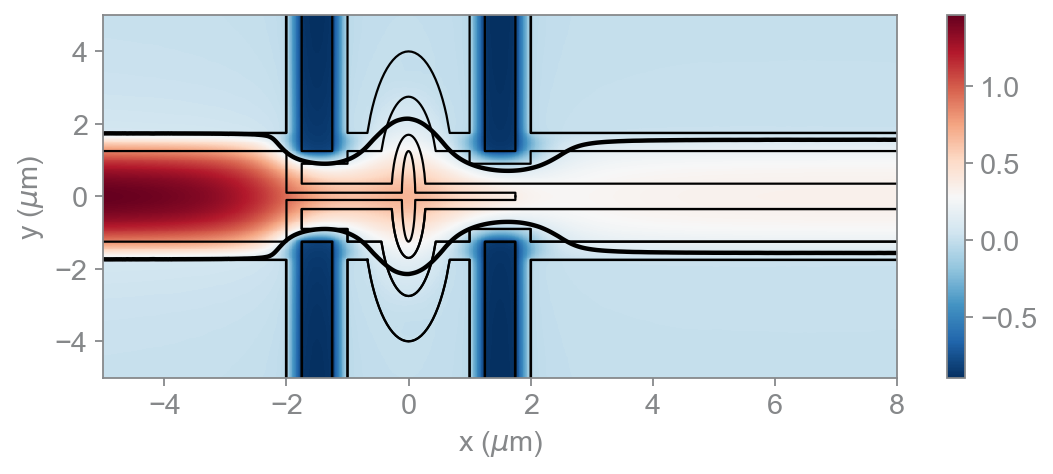

In [53]:
t = trap_analysis.TrapSolver()
#x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
x = output[0]['x']
y = output[0]['y']

import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (8., 3.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+0.6, trap=+2.5, resonatorguard=-1.0, trapguard=-1.0, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, chemical_potential=0.1, 
                            resonator_trap_locked=False, left_right_guard_locked=False, 
                            auto_scale=True):
    
    fig = plt.figure()
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
        
    coefficients = np.array([resonator, trap, resonatorguard, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V']
        else:
            combined_potential += coeff * output[k]['V']
    
    #combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    
    if not auto_scale:
        plt.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r)
    
    ymin, ymax = np.min(y), np.max(y)
    
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("y ($\mu$m)")
    plt.colorbar()
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(ymin, ymax)
    
    levels = np.array([chemical_potential])
    CS = plt.contour(x, y, combined_potential, levels, origin='lower', linewidths=2, colors='k')
    
    biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, trapguard * 10**scaling)
    
    anneal.draw_from_dxf(r"../simulation/exported_maxwell_data/Greater trap area/all_electrodes.dxf", color='k', lw=1)
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), chemical_potential=(-5, 5, 0.05), 
         resonator_trap_locked=False, left_right_guard_locked=False, auto_scale=True);

Finally, we plot a 1D slice through the center of the channel. This makes it easier to visualize the loading process.

-0.5670000000000002


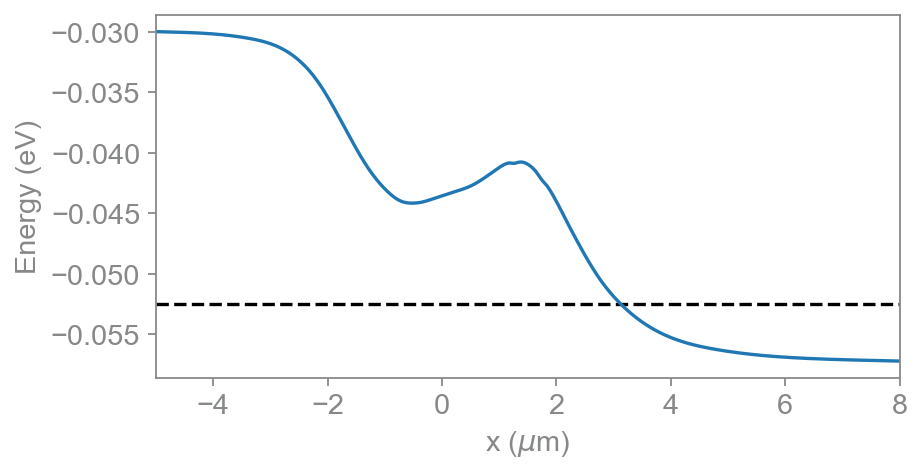

In [40]:
t = trap_analysis.TrapSolver()
x = output[0]['x']
y = output[0]['y']

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.,3.)

def plot_combined_potential(resonator=+0.10, trap=+0.05, resonatorguard=-0.05, centerguard=0.00, 
                            trapguard=-0.0, scaling=0.0, 
                            color_minimum=-0.10, color_maximum=0.10, chemical_potential=-0.0525, 
                            trap_resg_locked=False, left_right_guard_locked=False, 
                            auto_scale=False):
    
    fig = plt.figure(figsize=(6., 3.))
    plt1 = fig.add_subplot(111)
    
    if trap_resg_locked:
        resonatorguard = 1/0.25*(trap - 0.30)
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V']
        else:
            combined_potential += coeff * output[k]['V']
    
    TS = anneal.TrapAreaSolver(x[0,:], y[:,0], -combined_potential.T, smoothing=0.01)
    
    centeridx = int(np.shape(y)[0]/2)
    plt1.plot(x[0, :], TS.V(x[0,:], 0))#, color='darkorange')
    plt1.hlines(chemical_potential, np.min(x[0,:]), np.max(x[0,:]), linestyles='--')
        
    ymin, ymax = np.min(-combined_potential[centeridx,:]), np.max(-combined_potential[centeridx,:])
    
    print(x[0, np.argmin(-combined_potential[centeridx,:int(np.shape(combined_potential)[1]/2)])])
    plt.ylabel("Energy (eV)")
    plt.xlim(np.min(x), np.max(x))
    if not auto_scale:
        plt.ylim(color_minimum, color_maximum)
    else:
        color_minimum, color_maximum = plt.ylim()
        
    biasVoltages = "$V_{res}$ = %.4f\n$V_{trap}$ = %.4f\n$V_{rguard}$ = %.4f\n$V_{tguard}$ = %.4f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, trapguard * 10**scaling)
    
    plt.xlabel("x ($\mu$m)")

    
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), centerguard=(-5,5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         chemical_potential=(-5, 5, 0.05), color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), 
         trap_resg_locked=False, left_right_guard_locked=False, auto_scale=True);

# Trap area simulation

The goal of this section is to explore the dot potential in detail. We use a different exported simulation file compared with previous section, because we require a higher resolution in the trap area to fit to the dot potential and extract parameters such as natural frequency, anharmonicity. Again, make sure you have the 4 required files, named
- Resonator.dsp
- Trap.dsp
- ResonatorGuard.dsp
- TrapGuard.dsp

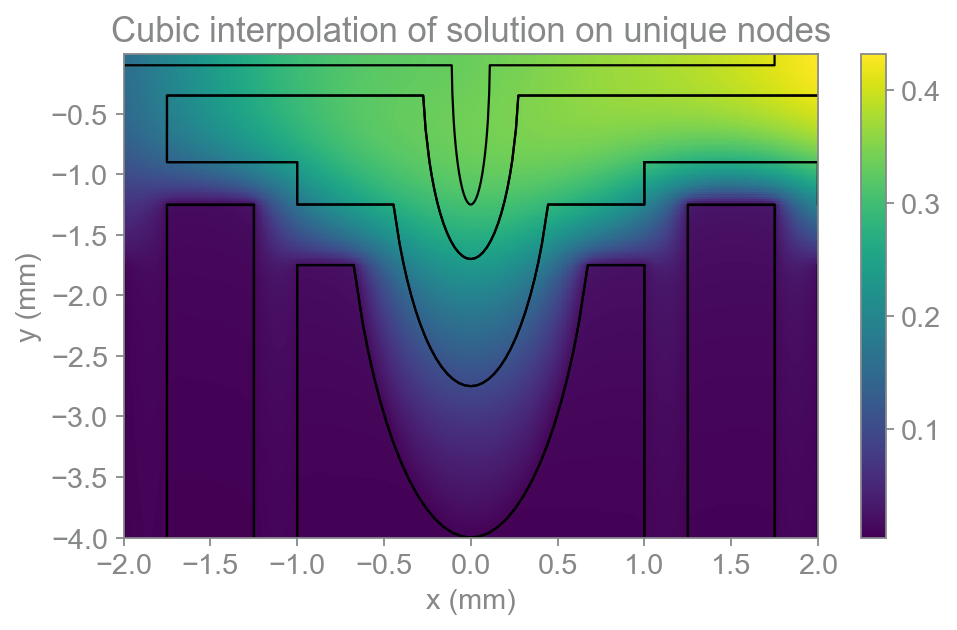

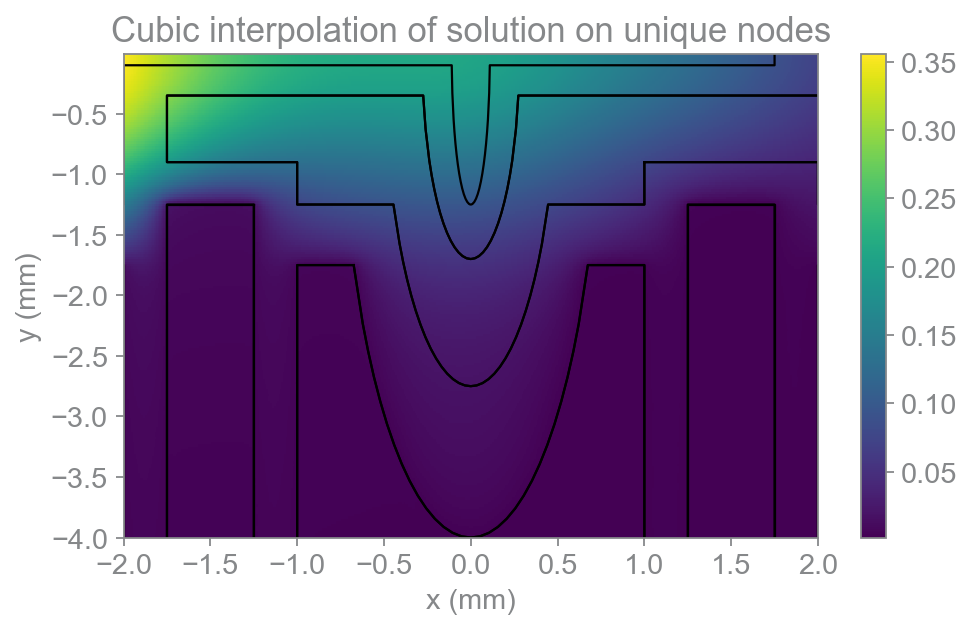

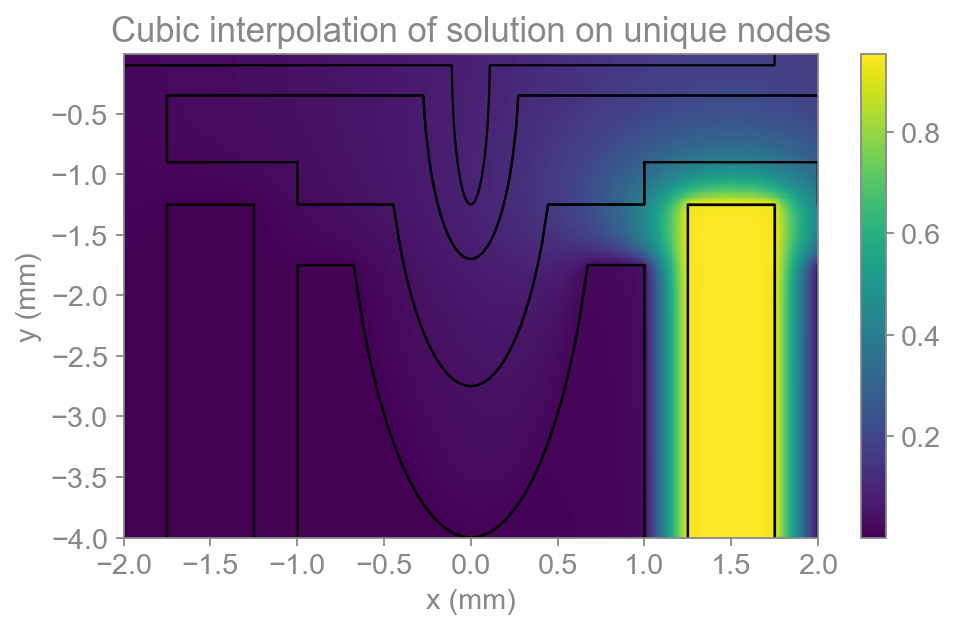

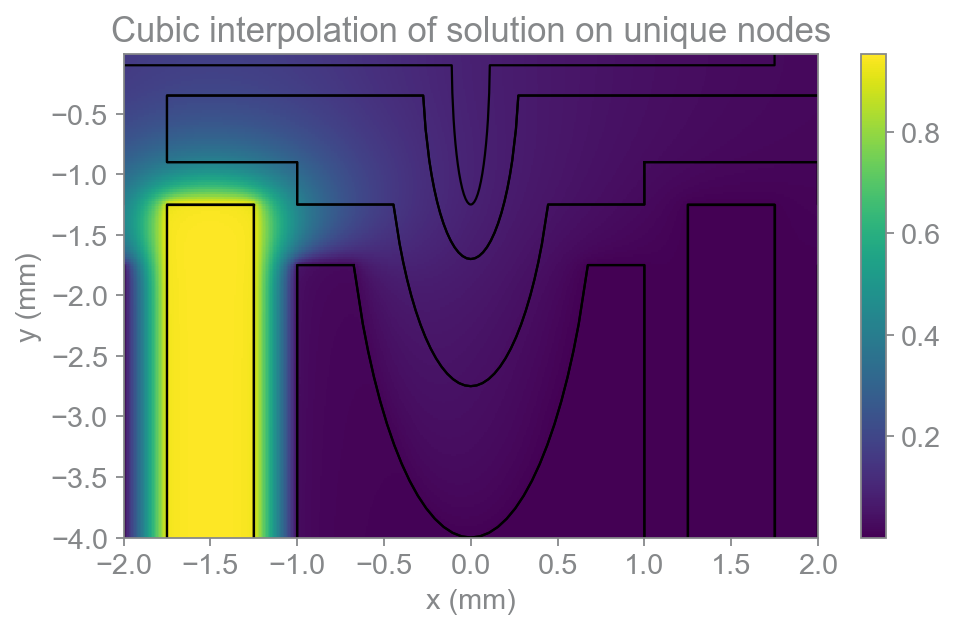

In [54]:
# Evaluate all files in the range
xeval = np.linspace(-2, 2, 501)
yeval = anneal.construct_symmetric_y(-4, 201)

mother_path = r"../simulation/exported_maxwell_data/Dot area (high resolution)"
datafiles = [r"Resonator.dsp", r"Trap.dsp", "ResonatorGuard.dsp", "TrapGuard.dsp"]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(7.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(mother_path, datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                         plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False, do_plot=1)
    
    
    anneal.draw_from_dxf(r"../simulation/exported_maxwell_data/Dot area (high resolution)/all_electrodes.dxf", color='k', lw=1)
    
    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((2 * ysize, xsize))
    Uinterp_symmetric[:ysize, :] = Uinterp
    Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

    y_symmetric = np.zeros((2 * ysize, xsize))
    y_symmetric[:ysize, :] = yinterp
    y_symmetric[ysize:, :] = -yinterp[::-1, :]

    x_symmetric = np.zeros((2 * ysize, xsize))
    x_symmetric[:ysize, :] = xinterp
    x_symmetric[ysize:, :] = xinterp
    
    output.append({'name' : name, 
                   'V' : np.array(Uinterp_symmetric, dtype=np.float64),
                   'x' : np.array(x_symmetric, dtype=np.float64), 
                   'y' : np.array(y_symmetric, dtype=np.float64)})

0.0 0.0 4.0 -4.0
Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  =====================  ======================
Parameter            Value                   Std
===========  =====================  ======================
a0            0.39546934095583447   3.0364806337032064e-07
a1           -0.033682990456612084  2.8875959310225404e-05
a2           -0.03311504371103753   0.0004883745502158561
===========  =====================  ======================


/Users/gkoolstra/anaconda/envs/qnl_trajectories/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


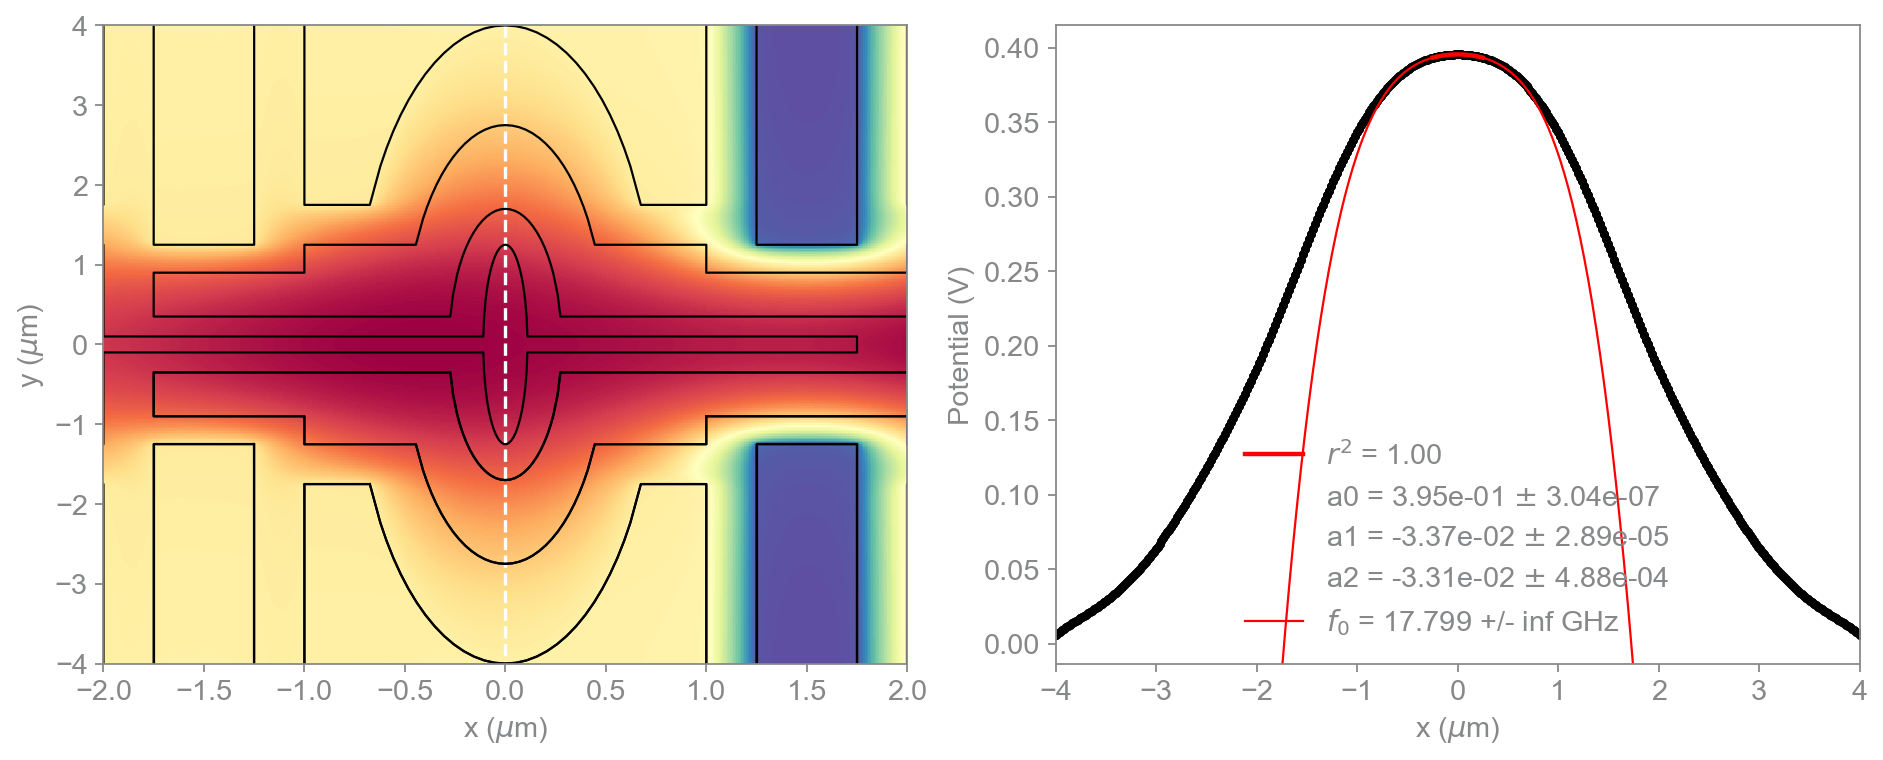

In [56]:
t = trap_analysis.TrapSolver()
x = output[0]['x']
y = output[0]['y']

common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (12.,5.)

def plot_combined_potential(resonator=+1.00, trap=0.5, resonatorguard=-0.5, trapguard=-0.0, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, fit_x = 0.0, 
                            resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=True, 
                            auto_scale=True):
    
    fig = plt.figure()
    plt1 = fig.add_subplot(1,2,1)
    plt2 = fig.add_subplot(1,2,2)
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V']
        else:
            combined_potential += coeff * output[k]['V']    
    
    if not auto_scale:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.Spectral_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.Spectral_r)
    
    if fit_potential_minimum:
        trap_xmin, trap_xmax = (-1.5, 1.5)
        trap_ymin, trap_ymax = (-3.0, 3.0)
        trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
        trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)
        
        print(trap_xmin_idx, trap_xmax_idx)
        print(trap_ymin_idx, trap_ymax_idx)
        
        yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                              ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
        yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
    else: 
        yidx = np.array([common.find_nearest(y[:,0], 0.0)])
        xidx = common.find_nearest(x[0,:], fit_x)
    
    plt1.plot([x[-1,xidx],x[0,xidx]], [y[-1,xidx], y[0,xidx]], '--', color='white')
    plt1.set_xlim(np.min(x), np.max(x))
    plt1.set_ylim(np.min(y), np.max(y))
    print(x[-1,xidx],x[0,xidx], y[-1,xidx], y[0,xidx])
    
    anneal.draw_from_dxf(r"../simulation/exported_maxwell_data/Dot area (high resolution)/all_electrodes.dxf", ax=plt1, color='k', lw=1)
    
    plt1.set_xlabel("x ($\mu$m)")
    plt1.set_ylabel("y ($\mu$m)")
    
    Vdata = combined_potential[:,xidx]
    xdata = y[:,xidx]
    plt2.plot(xdata, Vdata, '.k')
    
    fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=True)
    f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    
    fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1, 2], mode='even', domain=(-0.25, +0.25))
    plt2.plot(xdata, kfit.polyfunc_even(xdata, *fr), '-r', lw=1.0, label="$f_0$ = %.3f +/- %.3f GHz"%(f0/1E9, sigmaf0/1E9))
    plt.legend(loc=0, frameon=False)
    plt2.set_xlabel("x ($\mu$m)")
    plt2.set_ylabel("Potential (V)")
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    biasVoltages = "$V_{res}$ = %.3f\n$V_{trap}$ = %.3f\n$V_{rguard}$ = %.3f\n$V_{tguard}$ = %.3f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, trapguard * 10**scaling)
    
    fig.tight_layout()
    plt.show()
    
    
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         color_minimum=(-5, 5, 0.001), color_maximum=(-5, 5, 0.001),
         fit_x = (-1, 6, 0.05), 
         resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=False, 
         auto_scale=True);

# Curvature as a function of $V_\mathrm{rg}$ and $V_\mathrm{trap}$

This is the last stage of the simulations, where we use the data from the previous section to explore the trap curvature (i.e. single electron frequency) as function of the two electrode voltages $V_\mathrm{rg}$ and $V_\mathrm{trap}$.

In [7]:
def Vtrap_expt(Vrg, mu):
    f_mu = -1.755-7*mu
    print(f_mu)
    return (f_mu-0.120) - 1.15*Vrg

def Vtrap_th_expt(Vrg, mu):
    return (-0.120 - 1.69 * mu)*np.ones(len(Vrg))

def Vtrap_IsoBarrier_expt(Vrg, contour):
    return 0.32 + 10 * contour + 1.15 * Vrg

def Vrg_IsoBarrier_expt(Vtrap, contour):
    return 1/1.15 * (Vtrap - 0.32 - 10 * contour)

In the cell below, we define the constant resonator voltage and constant trap guard voltage, and also define the sweep range for the trap and resonator guard voltage. Set `fit_potential_minimum = True` to let the code find the minimum coordinates of the potential, and fit the potential at these coordinates (Note, this can become unstable if your minimum lies outside the dot, which can happen for large $V_\mathrm{trap}$). You can also force the code to fit a slice at a specific coordinate along the channel. In this case set `fit_potential_minimum = False` and specify the coordinate in microns with `fit_x = ....`.

In [8]:
#x, y, cropped_potentials = t.crop_potentials(output, xdomain=(-2.0,2.0), ydomain=(-1.5, 1.5))
x = output[0]['x']
y = output[0]['y']

resonator = 0.60
Vtraps = np.arange(0.00, 0.500, 0.005)
Vresguards = np.arange(0.00, -0.500, -0.005)
trapguard = +0.00

mu = -0.25
fit_x = 0.5
fit_potential_minimum=True

efreqs_x = np.zeros((len(Vtraps), len(Vresguards)))
efreqs_y = np.zeros((len(Vtraps), len(Vresguards)))
xposition = np.zeros((len(Vtraps), len(Vresguards)))
barrier_height = np.zeros((len(Vtraps), len(Vresguards)))
barrier_height_minus_trap = np.zeros((len(Vtraps), len(Vresguards)))
barrier_minus_mu = np.zeros((len(Vtraps), len(Vresguards)))
trap_level = np.zeros((len(Vtraps), len(Vresguards)))
quartic_term = np.zeros((len(Vtraps), len(Vresguards)))
quadratic_term = np.zeros((len(Vtraps), len(Vresguards)))

for n, trap in tqdm(enumerate(Vtraps)):
    for m, resonatorguard in enumerate(Vresguards):    
        coefficients = np.array([resonator, trap, resonatorguard, trapguard])

        for k, coeff in enumerate(coefficients):
            if k == 0: 
                combined_potential = coeff * output[k]['V']
            else:
                combined_potential += coeff * output[k]['V']    

        if fit_potential_minimum:
            trap_xmin, trap_xmax = (-1.5, 1.0)
            trap_ymin, trap_ymax = (-3.0, 3.0)
            trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
            trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)

            yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                                  ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
            yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
        else: 
            yidx = np.array([common.find_nearest(y[:,0], 0.0)])
            xidx = common.find_nearest(x[0,:], fit_x)

        f0s = list()
        quartic_terms_y, quartic_terms_x  = list(), list()
        quadratic_terms_y, quadratic_terms_x = list(), list()
        # Average f0 one index around the fit_x or potential minimum.
        for X in np.arange(xidx-1, xidx+1 + 1, 1):
            # Determine the electron motional frequency in the y-direction (across-channel)
            Vdata = combined_potential[:,X]
            xdata = y[:,X]
            center = y[yidx, X]
            
            # V = a0 + a1 x^2 + a2 x^4
            fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1, 2], mode='even', 
                                     domain=(-0.25, +0.25), verbose=False)
            a1, a2 = fr[1], fr[2]
            
            quartic_terms_y.append(a2)
            quadratic_terms_y.append(a1)
            
            # Then determine the electron motional frequency in the x-direction (along channel)
            # There is a double well, calculate the minimum according to the fit (take the positive solution)
            xdata = x[yidx, :]
            Vdata = combined_potential[yidx, :]
            center = x[yidx, X]
            
            # V = a0 + a1 (x - a2)^2
            try:
                fr, ferr = kfit.fit_parabola(xdata, Vdata, fitparams=[0, 1, center], verbose=False, 
                                             domain=(center-0.25, center+0.25))
                a1, a2 = fr[1], fr[2]
            except:
                a1, a2 = np.nan, np.nan
            
            quadratic_terms_x.append(a1)
        
        if np.mean(quartic_terms_y) < 0 and np.mean(quadratic_terms_y) > 0:
            # If there's a double well
            efreqs_y[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * -4 * np.mean(quadratic_terms_y) * 1E12 / me) 
            efreqs_x[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me) 
        else:
            efreqs_y[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_y) * 1E12 / me)
            efreqs_x[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me)
        
        res_barrier = (1.0, 2.0)
        res_barrier_min_idx = common.find_nearest(x[0,:], res_barrier[0])
        res_barrier_max_idx = common.find_nearest(x[0,:], res_barrier[1])
        trap_level_idx = common.find_nearest(x[0,:], -5.0)
        
        trap_barrier = (-2.5, -1.0)
        trap_barrier_min_idx = common.find_nearest(x[0,:], trap_barrier[0])
        trap_barrier_max_idx = common.find_nearest(x[0,:], trap_barrier[1])
        
        quartic_term[n, m] = np.mean(quartic_terms_y)
        quadratic_term[n, m] = np.mean(quadratic_terms_y)
        
        xposition[n,m] = x[0, xidx]
#         barrier_height[n,m] = np.max(-combined_potential[int(len(y[:,0])/2), barrier_min_idx:barrier_max_idx])
        barrier_height_minus_trap[n,m] = np.min([np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx], 
                                                np.max(-combined_potential[int(len(y[:,0])/2), trap_barrier_min_idx:trap_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx]])
        barrier_minus_mu[n,m] = np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) - mu
        trap_level[n,m] = -combined_potential[int(len(y[:,0])/2), trap_level_idx]

0it [00:00, ?it/s]<ipython-input-8-3ce0c1d3f429>:96: RuntimeWarning: invalid value encountered in sqrt
  efreqs_x[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me)
100it [01:17,  1.30it/s]


Let's plot the results. The color signifies the electron frequency $f_e$ in the across-channel direction and wherever there is white, the barrier height (calculated above) is negative. This means that there is no potential minimum to confine electrons.

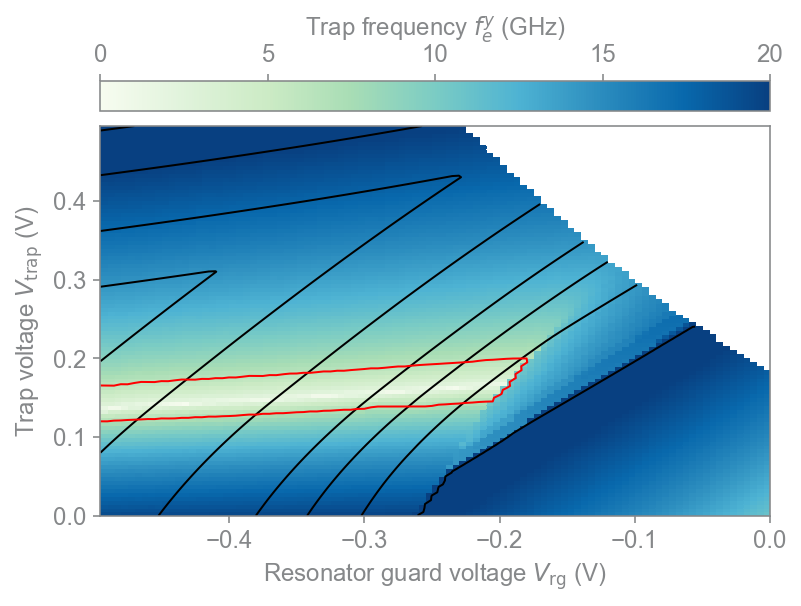

In [11]:
Em = np.ma.masked_where(barrier_minus_mu<0, efreqs_y/1E9)
Zm = np.ma.masked_where(barrier_minus_mu<0, barrier_height_minus_trap) * 1E3
levels = np.arange(0, 16, 4).tolist() + np.arange(20, 50, 10).tolist()

fig=plt.figure(figsize=(6, 4))
common.configure_axes(12)

gs1 = matplotlib.gridspec.GridSpec(10, 1, hspace=0.5)
ax1 = fig.add_subplot(gs1[1:, 0])
cbar_ax = fig.add_subplot(gs1[0, 0])

pcm = ax1.pcolormesh(Vresguards, Vtraps, Em, cmap=plt.cm.GnBu, vmin=0, vmax=20, rasterized=True)
cbar = plt.colorbar(pcm, ax=ax1, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel("Trap frequency $f_e^y$ (GHz)")
cbar.set_ticks([0, 5, 10, 15, 20])
cbar_ax.xaxis.tick_top()
cbar_ax.xaxis.set_label_position('top') 
ax1.set_xlim(np.min(Vresguards), np.max(Vresguards))
ax1.set_ylim(np.min(Vtraps), np.max(Vtraps))
ax1.set_xlabel("Resonator guard voltage $V_\mathrm{rg}$ (V)")
ax1.set_ylabel("Trap voltage $V_\mathrm{trap}$ (V)")

xline = np.linspace(-0.6, 0.0, 100)
CS = ax1.contour(Vresguards, Vtraps, Zm, colors='black', levels=levels, linewidths=1)
ax1.contour(Vresguards, Vtraps, Em, colors='red', levels=[6.5], linewidths=1)

Let's also visualize the electrostatic potential depth as function of the two voltages (here shown as the contours). This shows us when we expect electrons to escape from the dot.  Different contours show the barrier height in meV.

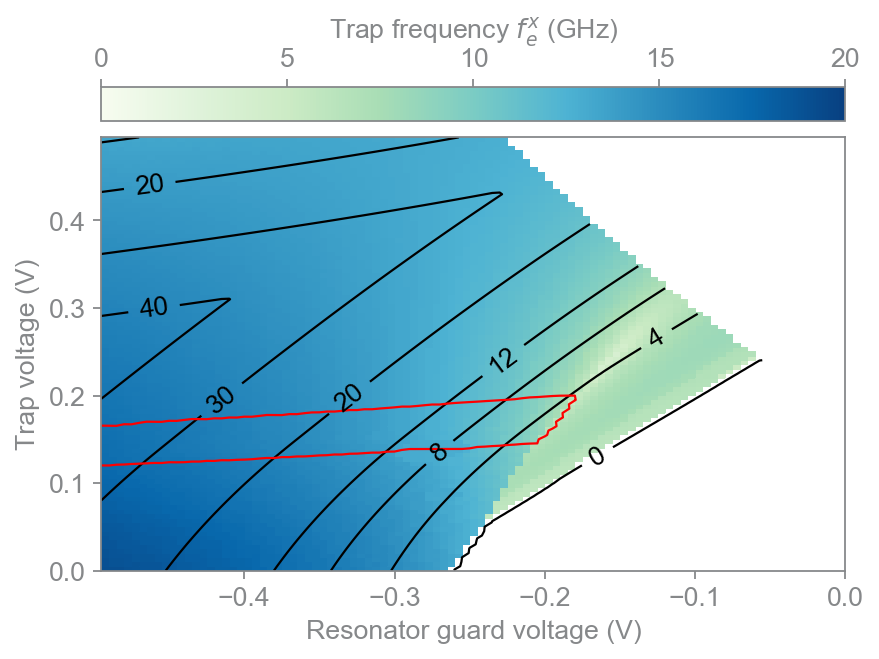

In [15]:
Em_x = np.ma.masked_where(barrier_minus_mu<0, efreqs_x/1E9)
Zm = np.ma.masked_where(barrier_minus_mu<0, barrier_height_minus_trap) * 1E3
levels = np.arange(0, 16, 4).tolist() + np.arange(20, 50, 10).tolist()

fig=plt.figure(figsize=(6, 4))
common.configure_axes(12)

gs1 = matplotlib.gridspec.GridSpec(10, 1, hspace=0.5)
ax1 = fig.add_subplot(gs1[1:, 0])
cbar_ax = fig.add_subplot(gs1[0, 0])

pcm = ax1.pcolormesh(Vresguards, Vtraps, Em_x, cmap=plt.cm.GnBu, vmin=0, vmax=20, rasterized=True)
cbar = plt.colorbar(pcm, ax=ax1, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel("Trap frequency $f_e^x$ (GHz)")
cbar.set_ticks([0, 5, 10, 15, 20])
cbar_ax.xaxis.tick_top()
cbar_ax.xaxis.set_label_position('top') 
ax1.set_xlim(np.min(Vresguards), np.max(Vresguards))
ax1.set_ylim(np.min(Vtraps), np.max(Vtraps))
ax1.set_xlabel("Resonator guard voltage (V)")
ax1.set_ylabel("Trap voltage (V)")

xline = np.linspace(-0.6, 0.0, 100)
CS = ax1.contour(Vresguards, Vtraps, Zm, colors='black', levels=levels, linewidths=1)
ax1.clabel(CS, colors='black', inline=1, fontsize=12, fmt="%.0f")
# ax1.plot(xline[xline>-0.18], Vtrap_th_expt(xline[xline>-0.18], mu)+0.100, '--', lw=1.5, color='navy')
# ax1.plot(xline, -1.15*xline + f_mu(mu), '--', color='red', lw=1.5)
ax1.contour(Vresguards, Vtraps, Em, colors='red', levels=[6.5], linewidths=1)

### Trap frequency in the $y$-direction 

Another important design parameter is the single electron frequency in the along-channel direction. Ideally, this should be much larger than the frequency in the accross-channel direction (measured at the crossing voltage).

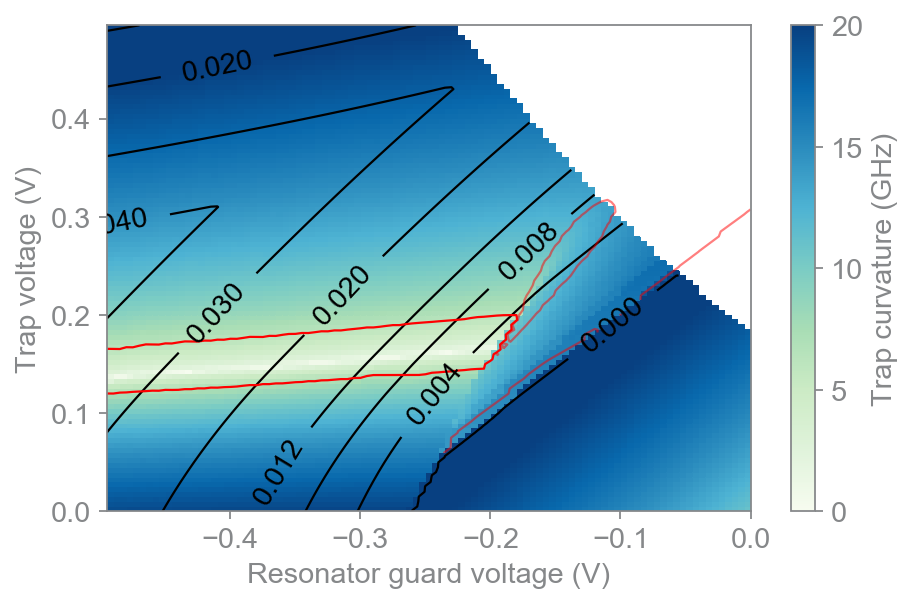

In [17]:
Em = np.ma.masked_where(barrier_minus_mu<0, efreqs_y/1E9)
Zm = np.ma.masked_where(barrier_minus_mu<0, barrier_height_minus_trap)
levels = np.arange(0, 0.016, 0.004).tolist() + np.arange(0.020, 0.050, 0.010).tolist()
fontsize = 13

fig=plt.figure(figsize=(6., 4.))
common.configure_axes(fontsize)
plt.pcolormesh(Vresguards, Vtraps, Em, cmap=plt.cm.GnBu, vmin=0, vmax=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Trap curvature (GHz)")
cbar.set_ticks([0, 5, 10, 15, 20])
plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.xlabel("Resonator guard voltage (V)")
plt.ylabel("Trap voltage (V)")

x = np.linspace(-0.6, 0.0, 100)
CS = plt.contour(Vresguards, Vtraps, Zm, colors='black', levels=levels, linewidths=1)
plt.clabel(CS, colors='black', inline=1, fontsize=fontsize)

mu = -0.27
def f_mu(mu):
    return -1.755-7*mu

x = np.linspace(-0.60, 0.00, 3)
Vtrap_park = 0.840
Vtrap_stop = 0.380

plt.contour(Vresguards, Vtraps, efreqs_x/1E9, colors='red', levels=[6.5], linewidths=1, alpha=0.5)
CS = plt.contour(Vresguards, Vtraps, Em, colors='red', levels=[6.5], linewidths=1)
fig.tight_layout()

Also, useful: the sensitivity of the electron frequency w.r.t. trap voltage. If there's any noise on the trap electrode (either ambient noise, ground loops, noisy source, etc) this will increase the dephasing. With this plot we can get a feeling of how bad the dephasing might be.

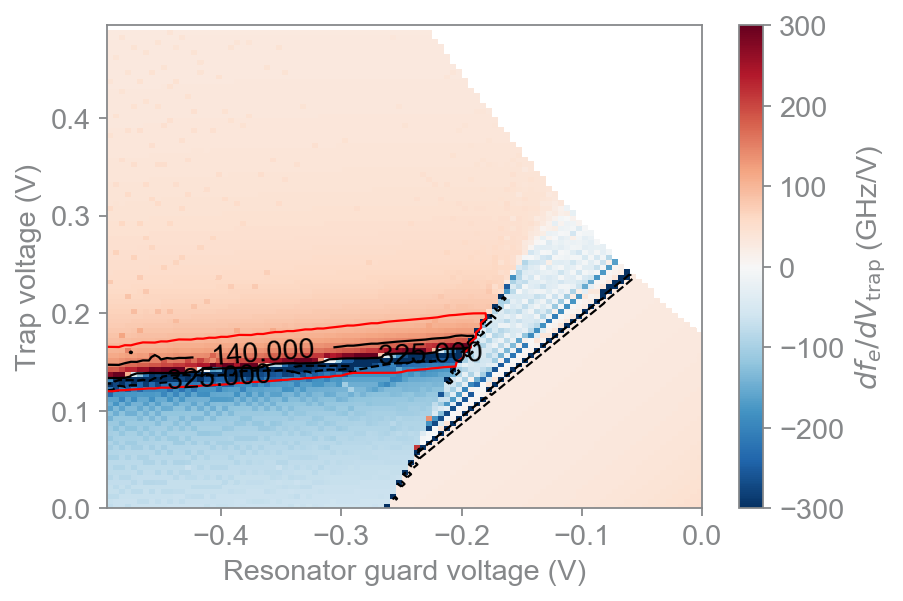

In [20]:
fig=plt.figure(figsize=(6., 4.))
common.configure_axes(fontsize)
plt.pcolormesh(Vresguards, Vtraps[:-1], np.diff(Em, axis=0)/np.diff(Vtraps)[0], cmap=plt.cm.RdBu_r, 
               vmin=-300, vmax=300)
cbar = plt.colorbar()
# cbar.set_label("GHz", labelpad=-10, x=1.10, y=1.10, rotation=0)
cbar.ax.set_ylabel("$d f_e / d V_\mathrm{trap}$ (GHz/V)")
plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.xlabel("Resonator guard voltage (V)")
plt.ylabel("Trap voltage (V)")

CS = plt.contour(Vresguards, Vtraps[:-1], np.diff(Em, axis=0)/np.diff(Vtraps)[0], 
                 levels=[-325, 140], colors='black', linewidths=1)
plt.clabel(CS, colors='black', inline=1, fontsize=fontsize)
plt.contour(Vresguards, Vtraps, Em, colors='red', levels=[6.5], linewidths=1)


### Anharmonicity

The anharmonicity is calculated from perturbation theory, see <a href="https://quantummechanics.ucsd.edu/ph130a/130_notes/node336.html">this</a> link

$$ \alpha/2\pi = \frac{3}{2\pi} \frac{e \hbar}{m_e^2 \omega_0^2} a_2 [\mathrm{V}/\mu\mathrm{m}^2] \cdot 1 \times 10^{24}$$

Here $a_2$ is the prefactor in the $x^4$ term in $V = a_0 + a_1 x^2 + a_2 x^4$

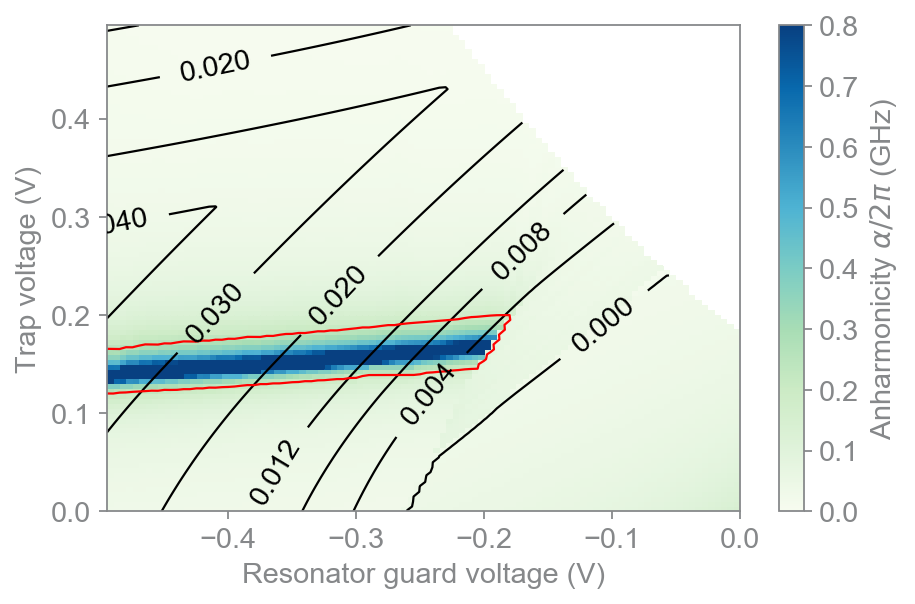

In [23]:
anharm_GHz = -1 / (2 * np.pi * 1E9) * 3 * qe * quartic_term * 1E24 * 1.055E-34 / (me**2 * (2 * np.pi * efreqs_y)**2)

Em = np.ma.masked_where(barrier_minus_mu<0, anharm_GHz)
Zm = np.ma.masked_where(barrier_minus_mu<0, barrier_height_minus_trap)
levels = np.arange(0, 0.016, 0.004).tolist() + np.arange(0.020, 0.050, 0.010).tolist()
fontsize = 13

fig=plt.figure(figsize=(6., 4.))
common.configure_axes(fontsize)
plt.pcolormesh(Vresguards, Vtraps, Em, cmap=plt.cm.GnBu, vmin=0, vmax=0.8)
cbar = plt.colorbar()
# cbar.set_label("GHz", labelpad=-10, x=1.10, y=1.10, rotation=0)
cbar.ax.set_ylabel(r"Anharmonicity $\alpha/2\pi$ (GHz)")
plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.xlabel("Resonator guard voltage (V)")
plt.ylabel("Trap voltage (V)")

x = np.linspace(-0.6, 0.0, 100)
CS = plt.contour(Vresguards, Vtraps, Zm, colors='black', levels=levels, linewidths=1)
plt.clabel(CS, colors='black', inline=1, fontsize=fontsize)
CS = plt.contour(Vresguards, Vtraps, efreqs_y/1E9, colors='r', levels=[6.5], linewidths=1)
fig.tight_layout()

Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  ===================  ===================
Parameter           Value                 Std
===========  ===================  ===================
a0           -2.8566666609354656  0.17654208282708253
a1           -6.933333321870929   0.35276681916987157
===========  ===================  ===================


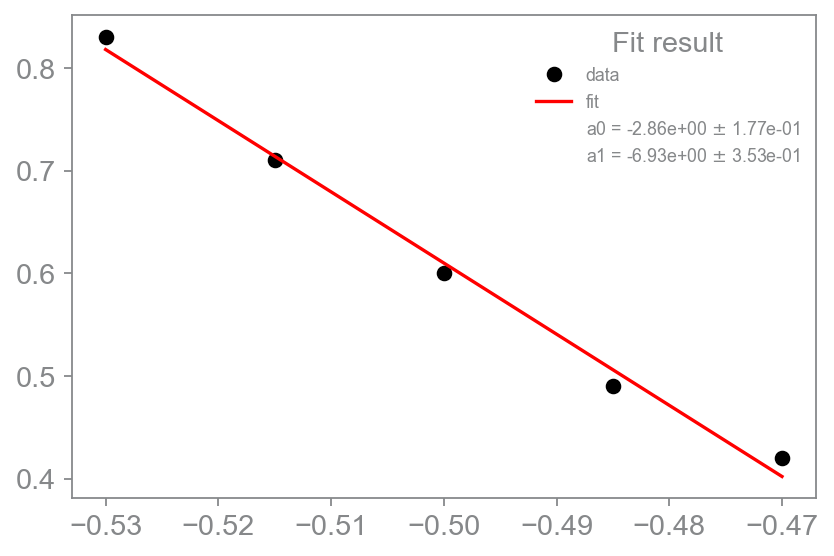

In [24]:
fr, ferr = kfit.fit_poly(np.array([-0.53, -0.515, -0.50, -0.485, -0.47]), 
                         np.array([0.83, 0.71, 0.60, 0.49, 0.42]), fitparams=[0.,1.0], showfit=True)

### Position of the electron

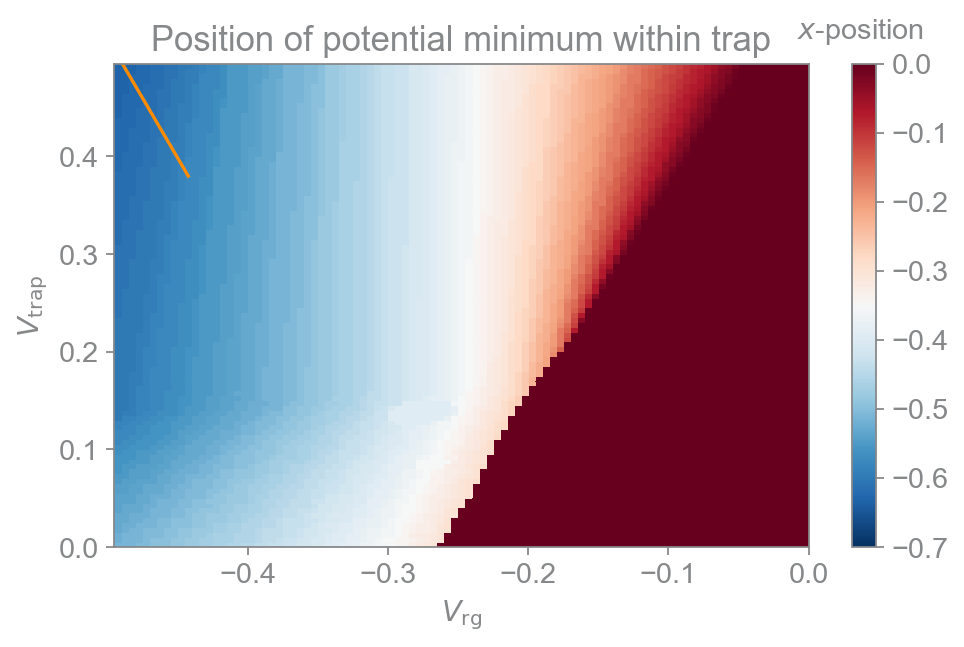

In [25]:
fig = plt.figure(figsize=(7.,4.))
common.configure_axes(13)
plt.pcolormesh(Vresguards, Vtraps, xposition,cmap=plt.cm.RdBu_r, vmin=-0.70, vmax=-0.00)
cbar = plt.colorbar()
cbar.set_label("$x$-position", labelpad=-40, x=1.10, y=1.10, rotation=0)
plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")
plt.title("Position of potential minimum within trap")

plt.plot([0, Vrg_start, Vrg_stop], [Vtrap_park, Vtrap_park, Vtrap_stop], '-', color='darkorange')

Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  =====================  ===================
Parameter            Value                  Std
===========  =====================  ===================
a0           -0.016571426748030242  0.02586740459599574
a1            -1.742857135877665    0.09897433488729707
===========  =====================  ===================


(0.0, 0.5)

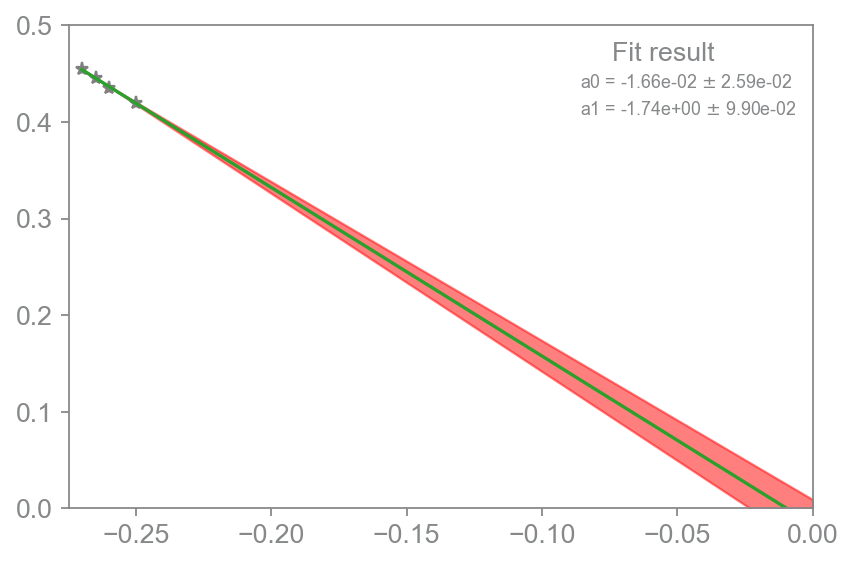

In [27]:
plt.figure()
common.configure_axes(12)
xs = np.array([-0.26, -0.265, -0.27, -0.25])
ys = np.array([0.315, 0.325, 0.335, 0.300]) + 0.120
fr, ferr = kfit.fit_poly(xs, ys, fitparams=[0, 1])
plt.plot(xs, ys, '*', color='gray')
xplots = np.linspace(-0.27, 0, 100)
plt.plot(xplots, kfit.polyfunc(xplots, *fr))
plt.fill_between(xplots, kfit.polyfunc(xplots, *fr+ferr), y2=kfit.polyfunc(xplots, *fr-ferr), alpha=0.5, color='r')
plt.xlim(-0.275, 0.000)
plt.ylim(0.0, 0.50)